Epoch [1/200] | Train Loss: 118.296207 | Val Loss: 17.059609
Epoch [2/200] | Train Loss: 8.948670 | Val Loss: 11.877750
Epoch [3/200] | Train Loss: 6.931740 | Val Loss: 10.476790
Epoch [4/200] | Train Loss: 6.438810 | Val Loss: 9.458504
Epoch [5/200] | Train Loss: 6.104236 | Val Loss: 8.805158
Epoch [6/200] | Train Loss: 5.058307 | Val Loss: 7.998741
Epoch [7/200] | Train Loss: 5.294198 | Val Loss: 7.860204
Epoch [8/200] | Train Loss: 4.492619 | Val Loss: 7.240928
Epoch [9/200] | Train Loss: 4.137276 | Val Loss: 6.796902
Epoch [10/200] | Train Loss: 4.367100 | Val Loss: 6.803152
Epoch [11/200] | Train Loss: 3.797847 | Val Loss: 7.238874
Epoch [12/200] | Train Loss: 3.806131 | Val Loss: 6.398249
Epoch [13/200] | Train Loss: 3.607086 | Val Loss: 6.101415
Epoch [14/200] | Train Loss: 3.860792 | Val Loss: 6.523835
Epoch [15/200] | Train Loss: 3.761363 | Val Loss: 6.359640
Epoch [16/200] | Train Loss: 3.776379 | Val Loss: 6.148408
Epoch [17/200] | Train Loss: 3.666619 | Val Loss: 6.343731
E

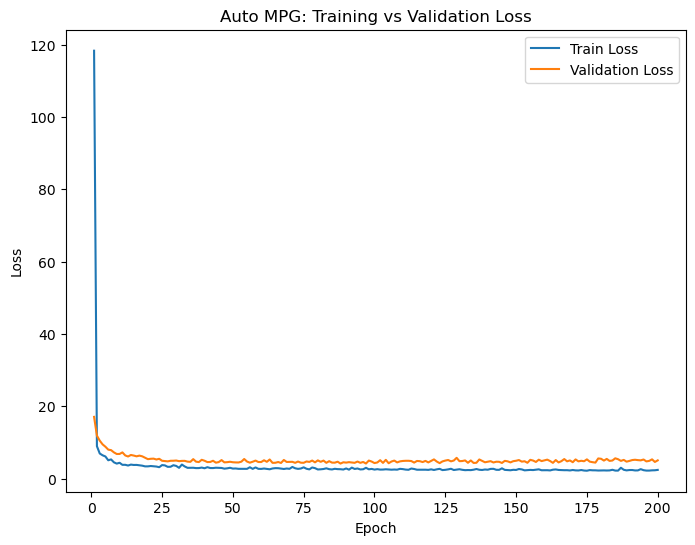


Sample predictions vs. true MPG:
Idx	Predicted	Actual
17	33.30		44.60
37	29.57		25.00
51	29.77		29.00
18	17.07		18.00
31	12.59		12.00
29	12.04		13.00
32	24.22		21.50
4	22.22		19.00
9	13.25		13.00
27	14.56		16.50
53	34.66		35.10
15	10.75		13.00
40	32.71		30.00
5	18.30		15.00
42	14.63		14.00
23	25.25		26.40
2	20.23		21.50
6	26.36		19.80
39	19.65		24.00
34	17.44		16.50


In [7]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
import requests

# Adjust this import to match your mlp.py location
from mlp import (
    Layer, MultilayerPerceptron,
    SquaredError, CrossEntropy,
    Tanh, Linear, 
    Relu, Softplus, Mish
)

def load_auto_mpg():
    """
    Reads the Auto MPG dataset from UCI or local file.
    Splits data into features (x) and target mpg (y).
    """
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
    r = requests.get(url)
    lines = r.text.strip().split('\n')

    x_list = []
    y_list = []
    for line in lines:
        parts = line.split()
        if len(parts) < 8:
            continue
        mpg_str = parts[0]
        # Skip lines with '?' in horsepower
        if '?' in parts[3]:
            continue

        try:
            mpg = float(mpg_str)
            # cylinders, displacement, horsepower, weight, acc, year, origin
            features = list(map(float, [
                parts[1],  # cylinders
                parts[2],  # displacement
                parts[3],  # horsepower
                parts[4],  # weight
                parts[5],  # acceleration
                parts[6],  # model year
                parts[7],  # origin
            ]))
        except ValueError:
            continue

        x_list.append(features)
        y_list.append(mpg)

    X = np.array(x_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32).reshape(-1, 1)

    # Simple normalization
    X_mean = X.mean(axis=0, keepdims=True)
    X_std  = X.std(axis=0, keepdims=True) + 1e-9
    X = (X - X_mean) / X_std

    return X, y

def main():
    # 1) Load data
    X, y = load_auto_mpg()
    n_samples = X.shape[0]

    # 2) Shuffle + split (70% train, 15% val, 15% test)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    train_end = int(0.70 * n_samples)
    val_end   = int(0.85 * n_samples)

    train_x, train_y = X[:train_end], y[:train_end]
    val_x,   val_y   = X[train_end:val_end], y[train_end:val_end]
    test_x,  test_y  = X[val_end:], y[val_end:]

    # 3) Build MLP for regression => e.g. 7 -> 16 -> 1
    layers = [
        Layer(fan_in=7, fan_out=16, activation_function=Tanh()),
        Layer(fan_in=16, fan_out=1, activation_function=Linear())
    ]
    mlp = MultilayerPerceptron(layers)

    # 4) Loss function => SquaredError for regression
    loss_func = SquaredError()

    # 5) Training params
    learning_rate = 1e-3
    batch_size    = 16
    epochs        = 200

    # 6) Train
    train_losses, val_losses = mlp.train(
        train_x, train_y,
        val_x,   val_y,
        loss_func=loss_func,
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=epochs
    )

    # 7) Evaluate on test (disable dropout by setting training=False)
    pred_test = mlp.forward(test_x, training=False)
    test_loss = loss_func.loss(test_y, pred_test)
    print(f"Test Loss (MSE-like): {test_loss:.4f}")

    # 8) Plot training & validation losses
    plt.figure(figsize=(8,6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses,   label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Auto MPG: Training vs Validation Loss')
    plt.legend()
    plt.show()

    # 9) Print sample predictions
    sample_indices = np.random.choice(test_x.shape[0], 20, replace=False)
    print("\nSample predictions vs. true MPG:")
    print("Idx\tPredicted\tActual")
    for idx in sample_indices:
        print(f"{idx}\t{pred_test[idx,0]:.2f}\t\t{test_y[idx,0]:.2f}")


if __name__ == "__main__":
    main()
